Disclaimer:

This is a coarse version of a tutorial. A lot of things are wrong. But they will be refined as we move.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (
    MultibodyPlant,
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    Parser,
    VectorSystem,
    VectorLogSink,
    Simulator,
    PlanarSceneGraphVisualizer,
    Multiplexer,
    plot_system_graphviz,
    MatrixGain,
    MeshcatVisualizer,
    StartMeshcat
    )

Think of pydrake as simulink. Each block will have an input and output port. We need to specify these things to define a robot or a block. 

Leafsystem: A template wrapper for each block. More on that later. 
Context: All information of the simulation environment at current timestep. 
BasicVector: Like C++ vector, drake needs that format

Basics of simulation are as follows:
- Build few blocks and specify i/o ports
- Build a diagram, where you specify the connections between blocks
- Now you can add that diagram to the simulator. Get context from it and set state/advance whatever.

[[1.         0.8        0.64       0.512      0.4096     0.32768
  0.262144   0.2097152  0.16777216 0.13421773 0.10737418]]


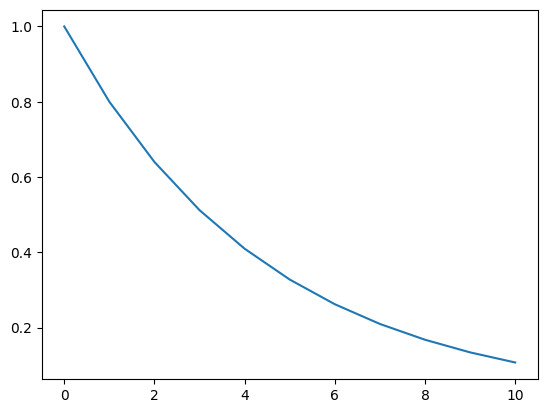

In [9]:
from pydrake.all import (LeafSystem, BasicVector, ConstantVectorSource, LogVectorOutput)

class sinFunctionSimulator(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        states = 1
        num_in = 1
        num_out = 1 
        #Define Num States
        self.DeclareDiscreteState(states)
        #Define num input
        self.DeclareVectorInputPort("u", BasicVector(num_in))
        #Define num out
        self.DeclareVectorOutputPort("y", BasicVector(num_in), self.cbOut)
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=1.0,  # One second time step.
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.


    def Update(self, context, discrete_state):
        #Get current state in np format
        x = context.get_discrete_state_vector().CopyToVector()
        #x[n+1] = 0.8x
        xnext = 0.8*x
        #Update the current State
        discrete_state.get_mutable_vector().SetFromVector(xnext)
    
    def cbOut(self, context, output):
        output.SetFromVector(context.get_discrete_state_vector().CopyToVector())


## Simulation Procedure
builder = DiagramBuilder()
sys = builder.AddSystem(sinFunctionSimulator())
stepINput = builder.AddSystem(ConstantVectorSource([1]))
builder.Connect(stepINput.get_output_port(0), sys.get_input_port(0))
logger = LogVectorOutput(sys.get_output_port(0), builder)
diagram = builder.Build()

context = diagram.CreateDefaultContext()
context.SetDiscreteState([1])
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(),log.data().transpose())
plt.show()